# #Part 1- Sentiment

# 1. Problem Statement


The reviews that a videogame recieves on steam is related with the amount of poblissity it gets. On  the steam reviews either recommend the game or dont recommend the game, this is very ambiguous to the degree that a reviewer makes their decision.

The overall success a videogame recieves is not solely a result of the summation of reviews, however I plan to determine a relationship between the sentiment of a review, and the amount of time that reviewer has played the videogame that they reviewed. In theory, the more positive someone's review would influence how much they play int he future after posting that review.

In [3]:
import pandas as pd
import numpy as np
import pickle
import math
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import unirest
import datetime
import patsy
from requests import get
from string import find
from string import digits
from textblob import TextBlob

from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict

import valve.steam.id as sid

from nltk.corpus import stopwords
from sklearn.lda import LDA
from lxml import html


%matplotlib inline

/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and w

In [4]:
#Reading in the data
dota = 'Dota_2.jsonlines.txt'
elder = 'The_Elder_Scrolls_V.jsonlines.txt' 
tf2 = 'Team_Fortress_2.jsonlines.txt'
civ = 'Sid_Meiers_Civilization_5.jsonlines.txt'
gta = 'Grand_Theft_Auto_V.jsonlines.txt'
gmod = 'Garrys_Mod.jsonlines.txt'
fbm = 'Football_Manager_2015.jsonlines.txt'
csgo = 'Counter_Strike_Global_Offensive.jsonlines.txt'
cs = 'Counter_Strike.jsonlines.json'
warframe = 'Warframe.jsonlines.txt'
arma = 'Arma_3.jsonlines.json'

dota_data = []
with open(dota) as data_file:
    for line in data_file:
        dota_data.append(json.loads(line))
elder_data = []
with open(elder) as data_file:
    for line in data_file:
        elder_data.append(json.loads(line))
tf2_data = []
with open(tf2) as data_file:
    for line in data_file:
        tf2_data.append(json.loads(line))
civ_data = []        
with open(civ) as data_file:
    for line in data_file:
        civ_data.append(json.loads(line))
gta_data = []       
with open(gta) as data_file:
    for line in data_file:
        gta_data.append(json.loads(line))
gmod_data = []        
with open(gmod) as data_file:
    for line in data_file:
        gmod_data.append(json.loads(line))
fbm_data = []        
with open(fbm) as data_file:
    for line in data_file:
        fbm_data.append(json.loads(line))
csgo_data = []        
with open(csgo) as data_file:
    for line in data_file:
        csgo_data.append(json.loads(line))
cs_data = []        
with open(cs) as data_file:
    for line in data_file:
        cs_data.append(json.loads(line))
warframe_data = []      
with open(warframe) as data_file:
    for line in data_file:
        warframe_data.append(json.loads(line))
arma_data = []        
with open(arma) as data_file:
    for line in data_file:
        arma_data.append(json.loads(line))
        
dota_df = pd.DataFrame(dota_data)
print "Shape of dota data = ", dota_df.shape
elder_df = pd.DataFrame(elder_data)
print "Shape of elderscrolls data = ", elder_df.shape
tf2_df = pd.DataFrame(tf2_data)
print "Shape of tf2 data = ",tf2_df.shape
civ_df = pd.DataFrame(civ_data)
print "Shape of civ data = ", civ_df.shape
gta_df = pd.DataFrame(gta_data)
print "Shape of gta data = ", gta_df.shape
gmod_df = pd.DataFrame(gmod_data)
print "Shape of gmod data = ", gmod_df.shape
fbm_df = pd.DataFrame(fbm_data)
print "Shape of football manager data = ", fbm_df.shape
csgo_df = pd.DataFrame(csgo_data)
print "Shape of csgo data = ", csgo_df.shape
cs_df = pd.DataFrame(cs_data)
print "Shape of cs data = ", cs_df.shape
warframe_df = pd.DataFrame(warframe_data)
print "Shape of warframe data = ", warframe_df.shape
arma_df = pd.DataFrame(arma_data)
print "Shape of arma data = ", arma_df.shape

Shape of dota data =  (9720, 27)
Shape of elderscrolls data =  (7165, 27)
Shape of tf2 data =  (5676, 27)
Shape of civ data =  (7467, 27)
Shape of gta data =  (13349, 27)
Shape of gmod data =  (7151, 27)
Shape of football manager data =  (1522, 27)
Shape of csgo data =  (7073, 27)
Shape of cs data =  (6040, 27)
Shape of warframe data =  (7123, 27)
Shape of arma data =  (7151, 27)


# 2. Description of Data

The data I used was obtained from a github user who was trying to predict user experience based on the reviews they scraped.

From this repo: https://github.com/mulhod/steam_reviews

The data consists of 28 columns:
u'achievement_progress' - three part  dictionary containing amount of possible achievements across games, amount of
achievements earned, and a percent representation of completion


Columns:
==================================================================

u'date_posted' - Timestamp representing the date at which the reviewer posted the review

u'date_updated' - Timestamp representing the most recent date at which the reviewer updated the review

u'found_helpful_percentage' - Percent representation of users who found the review helpful out of all users who voted that it was helpful or unhelpful

u'friend_player_level'

u'num_badges' - Number of Steam profile badges the user has accumulated

u'num_comments' - Number of comments on the review

u'num_found_funny' - Number of users who found the review funny

u'num_found_helpful' - Number of users who found the review helpful

u'num_found_unhelpful' - Number of users who found the review unhelpful

u'num_friends' - Number of friends the reviewer had

u'num_games_owned' - Number of games the reviewer owns

u'num_groups' - Number of groups the reviewer is a member of

u'num_guides' - Number of video-game guides the reviewer has created

u'num_reviews' - Number of reviews the reviewer has posted

u'num_screenshots' - Number of screenshots the reviewer has taken

u'num_voted_helpfulness' - Number of users who found the review helpful

u'num_workshop_items' - Number of workshop items the reviewer has created

u'orig_url'- Original URL of review   

u'profile_url' - Reviewer profile URL

u'rating' - Rating the reviewer gave the game either recommending the game, or not recommending the game

u'review' - Full body of review text

u'review_url' - URL corresponding to the review

u'steam_id_number' - 64-Bit Steam-ID number

u'total_game_hours' - Summative amount of hours game has been played

u'total_game_hours_last_two_weeks' - Total hours reviewer has played reviewed videogame in the past two weeks

u'username' - The user alias that in some cases, is part of the profile_URL               


# 3. Code relevant to cleaning

In [15]:
game_dfs = [dota_df, elder_df, tf2_df, civ_df, 
            gta_df, gmod_df, fbm_df, csgo_df, 
            cs_df, warframe_df, arma_df]

In [5]:
# Hardcoding in the game_ids so I can access them on the fly when retrieving updated hours played.
dota_df['game_id'] = 570
elder_df['game_id'] = 72850
tf2_df['game_id'] = 440
civ_df['game_id'] = 8930
gta_df['game_id'] = 271590
gmod_df['game_id'] = 4000
fbm_df['game_id'] = 295270
csgo_df['game_id'] = 730
cs_df['game_id'] = 10
warframe_df['game_id'] = 230410
arma_df['game_id'] = 107410

In [6]:
BASE = long(76561197960265728)
PREFIX = 'U:1:'
STEAM_COMMUNITY = 'http://steamcommunity.com/id/'
STEAM_API_KEY = '9322F9CA7232748D973D043702070B16'


########################################
# Class Courtesy of:                   #
# https://github.com/annasapek/steamid #
########################################

# For converting the 'Vanity URL' steam profile links to actual steam ids, usable by the steam web API
class NoSuchSteamIDError(Exception):
	pass

def get_64bit_steam_id(vanityurl):
	""" Retrieves the 64-bit Steam ID for the given vanity url
		eg. http://steamcommunity.com/id/vanityurl -> xxxxxxxxxxxxxxxxx
	
	"""	
	
	if vanityurl.startswith(STEAM_COMMUNITY):
		vanityurl = vanityurl[len(STEAM_COMMUNITY):]
	
	RESOLVE_VANITY_URL = \
		'http://api.steampowered.com/ISteamUser/ResolveVanityURL/v0001/?key=%s&vanityurl=%s'
	if vanityurl == None:
		raise ValueError('Must provide vanityurl')
		exit(1)
	else:
		result = get(RESOLVE_VANITY_URL % (STEAM_API_KEY, vanityurl))
		if result.status_code == 403:
			raise ValueError('Invalid Steam API key: %s' % STEAM_API_KEY)
		else:
			result.raise_for_status()
			data = result.json()
			if data['response']['success'] == 1:
				return data['response']['steamid']
			else:
				raise NoSuchSteamIDError('Could not resolve vanity url: %s' % vanityurl)
				exit(1)

def get_32bit_steam_id(vanityurl):
	""" Retrieves the 32-bit Steam ID for the given vanity url
		eg. http://steamcommunity.com/id/vanityurl -> U:1:XXXXXXXX
	
	"""
	
	steam_id = long(get_64bit_steam_id(vanityurl))
	return 'U:1:%s' % (steam_id - BASE)

def convert_32bit_to_64bit(steamid):
	""" Given a valid 32-bit Steam ID, in the form U:1:XXXXXX or XXXXXX, returns the 
		equivalent 64-bit Steam ID in the form xxxxxxxxxxxxxxxxx
	"""
	
	u_index = find(str(steamid), PREFIX)
	if u_index != -1:
		steamid = steamid[u_index + len(PREFIX):]
	validate_id_number(steamid)
	return str(long(steamid) + BASE)

def convert_64bit_to_32bit(steamid):
	""" Given a valid 64-bit Steam ID, in the form xxxxxxxxxxxxxxxxx, returns the 
		equivalent 32-bit Steam ID in the form U:1:XXXXXX
	"""
	
	validate_id_number(steamid)
	return 'U:1:%s' % (long(steamid) - BASE)

def validate_id_number(value):
	""" Given an id number, returns true if it only contains digits
	"""
	
	for char in str(value):
		if char not in digits:
			raise ValueError('%s is not a valid number' % value)

In [7]:
#Based on a "vanity" URL (URL: http://steamcommunity.com/id/<your alias>/), return the steam ID, if unretrievable, return NaN
def clean_df_profile_url(passed_df):
    game_id = passed_df.ix[0, 'game_id']
    #For each row, steamURL in passed_df
    for i, steam_url in enumerate(passed_df['profile_url']):
        try:
            # Try to fetch the steam ID
            steam_id = get_64bit_steam_id(str(steam_url))
            passed_df.ix[i, 'parsed_steam_ids'] = steam_id
        except:
            # If unretrievable set passed_df.ix[row, parsed_steam_ids] to NaN
            passed_df.ix[i, 'parsed_steam_ids'] = np.nan
    print game_id
    filepath = '../capstone/' + str(game_id) +'.pkl'
    pd.to_pickle(passed_df, filepath)
    print 'saved: ', filepath

In [8]:
def fetch_hours_played(passed_df):
    # Specific identifier for the game being parsed
    game_id = passed_df.ix[0, 'game_id']
    #For each row, steam ID available in passed_df
    for i, steam_id_ in enumerate(passed_df['parsed_steam_ids']):
        requestlink = 'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001?key=9322F9CA7232748D973D043702070B16&steamid='+ \
        str(steam_id_) + '&include_played_free_games=1&format=json'
        #If steam ID in row is not NaN from clean_df_profile_url
        if 'nan' not in requestlink:
            stats = requests.get(requestlink)
            content = stats.content
            formatted = json.loads(content)
            try:
                # For all games listed in JSON response, this encompasses all games for a steam user
                for x in formatted['response']['games']:
                    if x['appid'] == game_id:
                        passed_df.ix[i, 'hours_played_now'] = x['playtime_forever']
            except:
                #If the game reviwed was not found, set passed_df.ix[row, 'hours_played_now'] to nan
                passed_df.ix[i, 'hours_played_now'] =  np.nan
        else:
            #If the steam ID was a nan, set passed_df.ix[row, 'hours_played_now'] to nan
            passed_df.ix[i, 'hours_played_now'] = np.nan
    #Save a file specific to the game ID of the dataframe being traversed
    filepath = '../capstone/final_' + str(game_id) +'.pkl'
    pd.to_pickle(passed_df, filepath)
    print 'saved_final: ', filepath

In [9]:
# After getting steam ids and time played, pickled files:
dota_with_time = pd.read_pickle('../capstone/final_570.pkl')
elder_with_time = pd.read_pickle('../capstone/final_72850.pkl')
tf2_with_time = pd.read_pickle('../capstone/final_440.pkl')
civ_with_time = pd.read_pickle('../capstone/final_8930.pkl')
gta_with_time = pd.read_pickle('../capstone/final_271590.pkl')
gmod_with_time = pd.read_pickle('../capstone/final_4000.pkl')
fbm_with_time = pd.read_pickle('../capstone/final_295270.pkl')
csgo_with_time = pd.read_pickle('../capstone/final_730.pkl')
cs_with_time = pd.read_pickle('../capstone/final_10.pkl')
warframe_with_time = pd.read_pickle('../capstone/final_230410.pkl')
arma_with_time = pd.read_pickle('../capstone/final_107410.pkl')

In [10]:
#Subset data by items that have non-null values for the column pulled from the steam web API
dota_with_time_nonan = dota_with_time[pd.notnull(dota_with_time['hours_played_now'])]
elder_with_time_nonan = elder_with_time[pd.notnull(elder_with_time['hours_played_now'])]
tf2_with_time_nonan = tf2_with_time[pd.notnull(tf2_with_time['hours_played_now'])]
civ_with_time_nonan = civ_with_time[pd.notnull(civ_with_time['hours_played_now'])]
gta_with_time_nonan = gta_with_time[pd.notnull(gta_with_time['hours_played_now'])]
fbm_with_time_nonan = fbm_with_time[pd.notnull(fbm_with_time['hours_played_now'])]
gmod_with_time_nonan = gmod_with_time[pd.notnull(gmod_with_time['hours_played_now'])]
csgo_with_time_nonan = csgo_with_time[pd.notnull(csgo_with_time['hours_played_now'])]
cs_with_time_nonan = cs_with_time[pd.notnull(cs_with_time['hours_played_now'])]
warframe_with_time_nonan = warframe_with_time[pd.notnull(warframe_with_time['hours_played_now'])]
arma_with_time_nonan = arma_with_time[pd.notnull(arma_with_time['hours_played_now'])]

In [11]:
cleaned_dfs = [dota_with_time_nonan,  elder_with_time_nonan, tf2_with_time_nonan,
              fbm_with_time_nonan, gta_with_time_nonan, civ_with_time_nonan, 
              gmod_with_time_nonan, csgo_with_time_nonan, cs_with_time_nonan, 
              arma_with_time_nonan, warframe_with_time_nonan]

In [12]:
for x in cleaned_dfs:
    # Hours played gets returned from the steam web API in minutes
    x['hours_played_now'] = x['hours_played_now']/ 60.
    # Difference in hours played
    x['hours_played_diff'] = x['hours_played_now'] - x['total_game_hours']
    x['date_posted'] = pd.to_datetime(x['date_posted'])
    x['textblobobj'] = x['review'].map(TextBlob)
    # Making textblob objects and creating sentiment ratings of each of the reviews
    x['sentiment'] = x['textblobobj'].map(lambda z: z.sentiment[0])
    x['subjectivity'] = x['textblobobj'].map(lambda z: z.sentiment[1])

/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [13]:
# Some of the data was false in showingg the difference in time played as being than zero
# Subsetting to data only represenative of a positive chnge in hours played
dota_with_time_nonan_test = dota_with_time_nonan[dota_with_time_nonan['hours_played_diff'] > 0]
elder_with_time_nonan_test = elder_with_time_nonan[elder_with_time_nonan['hours_played_diff'] > 0]
tf2_with_time_nonan_test = tf2_with_time_nonan[tf2_with_time_nonan['hours_played_diff'] > 0]
civ_with_time_nonan_test = civ_with_time_nonan[civ_with_time_nonan['hours_played_diff'] > 0]
gta_with_time_nonan_test = gta_with_time_nonan[gta_with_time_nonan['hours_played_diff'] > 0]
fbm_with_time_nonan_test = fbm_with_time_nonan[fbm_with_time_nonan['hours_played_diff'] > 0]
gmod_with_time_nonan_test = gmod_with_time_nonan[gmod_with_time_nonan['hours_played_diff'] > 0]
csgo_with_time_nonan_test = csgo_with_time_nonan[csgo_with_time_nonan['hours_played_diff'] > 0]
cs_with_time_nonan_test = cs_with_time_nonan[cs_with_time_nonan['hours_played_diff'] > 0]
warframe_with_time_nonan_test = warframe_with_time_nonan[warframe_with_time_nonan['hours_played_diff'] > 0]
arma_with_time_nonan_test = arma_with_time_nonan[arma_with_time_nonan['hours_played_diff'] > 0]


# 4. EDA

In [16]:
eda_list = [dota_with_time_nonan_test,  elder_with_time_nonan_test, tf2_with_time_nonan_test,
              fbm_with_time_nonan_test, gta_with_time_nonan_test, civ_with_time_nonan_test, 
              gmod_with_time_nonan_test, csgo_with_time_nonan_test, cs_with_time_nonan_test, 
              arma_with_time_nonan_test, warframe_with_time_nonan_test]


# Looking at the overall difference in hours played amongst all videogames
list_to_plot = []
for x in eda_list:
    for y, z, a in zip(x['game_id'], x['rating'], x['hours_played_diff']):
        list_to_plot.append((y, str(z), a))

# Examining the counts of classes per game
list_to_plot_pre = []
for x in game_dfs:
    for y, z in zip(x['game_id'], x['rating']):
        list_to_plot_pre.append((y, str(z)))

# Looking at the difference in hours played over the timeseries span of the reviews
date_list = []
for x in eda_list:
    for y, z, a in zip(x['game_id'], x['date_posted'], x['hours_played_diff']):
        date_list.append((y, z, a))
        
pre_plott = pd.DataFrame(list_to_plot_pre)
plott = pd.DataFrame(list_to_plot)
date_plott = pd.DataFrame(date_list)

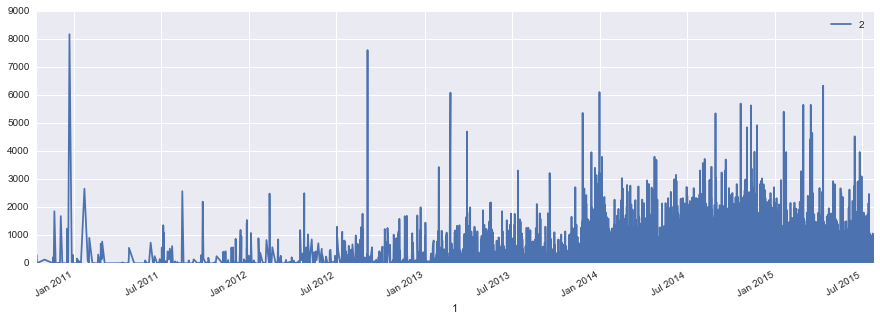

In [35]:
# Distributions of difference in hours played by post_date
date_plott.plot(1, 2, figsize=(15, 5))

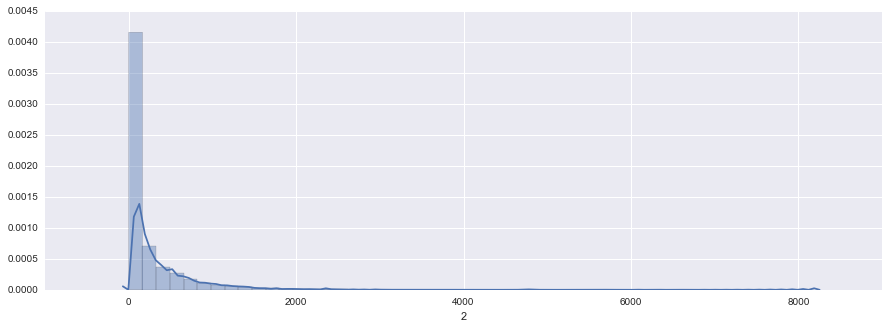

In [24]:
#distribution of difference in time played across games
ax = plt.figure(figsize=(15, 5))
ax = sns.distplot(plott[2])

ERROR! Session/line number was not unique in database. History logging moved to new session 550


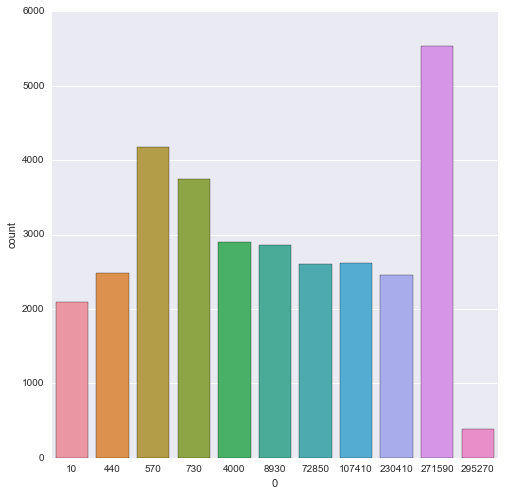

In [26]:
# Counts of reviews relative to one another
sns.set_style('darkgrid')
ax = plt.figure(figsize=(8,8))
ax = sns.countplot(x=0, data=plott)

From the original dataset totalling 79,437 reviews, only '' are left. Some of the user profiles in the original  dataset are unable to be retrieved, even after using the class I used from github. This won't be too big of a problem. Game '295270' won't be signifigant in my analysis as it has a fraction of the other reviews, but overall  the number of reviews across unique games is pretty similar ranging between 2000-4000. I also have an abundance of reviews for game '271590'.

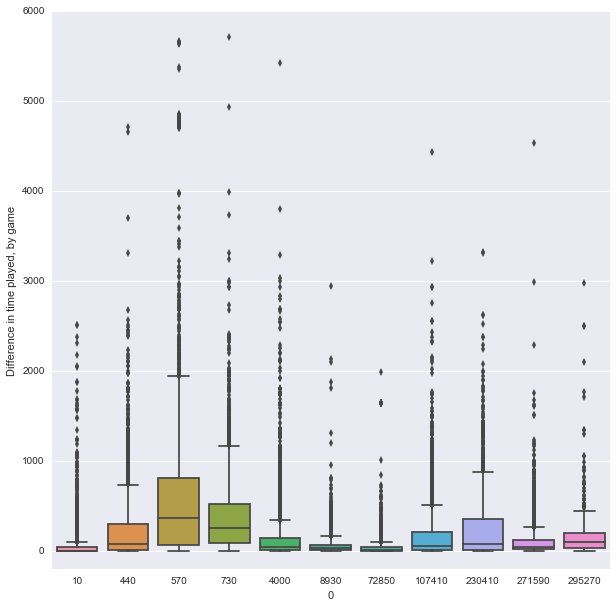

In [28]:
# Boxplot to show local maxima of difference in hours played amongst all videogames
ax = plt.figure(figsize=(10,10))
ax = plt.ylim(-200, 6000)
sns.boxplot(x=plott[0],  y=plott[2])
ax = plt.ylabel('Difference in time played, by game')

In this graph I am truncating outliers that have enormous differences in the time that they've played the game, as they are not representative of the population. Some of the games such as game 10 (Counter Strike) and 440 (Team Fortress 2) have higher differences than games like game 72850 (Skyrim) and 8930 (Sid Mier's Civilization 5) because of replayability. However Counterstrike and Team Fortress have lower differences overall because of how long ago they were released. 

With the case of Skyrim this could be due to any number of reasons as it was released November 11, 2011, Civ 5 being released September 21, 2010, whereas Counterstrike being released November 8, 2000, and Team Fortress 2 being released October 9, 2007. This is important as even years later, with the earliest review of my reviews being in 2010 there is definetly signifigance in the fact that people are still reviewing the game years after release, specifically in the case of Counterstrike.}

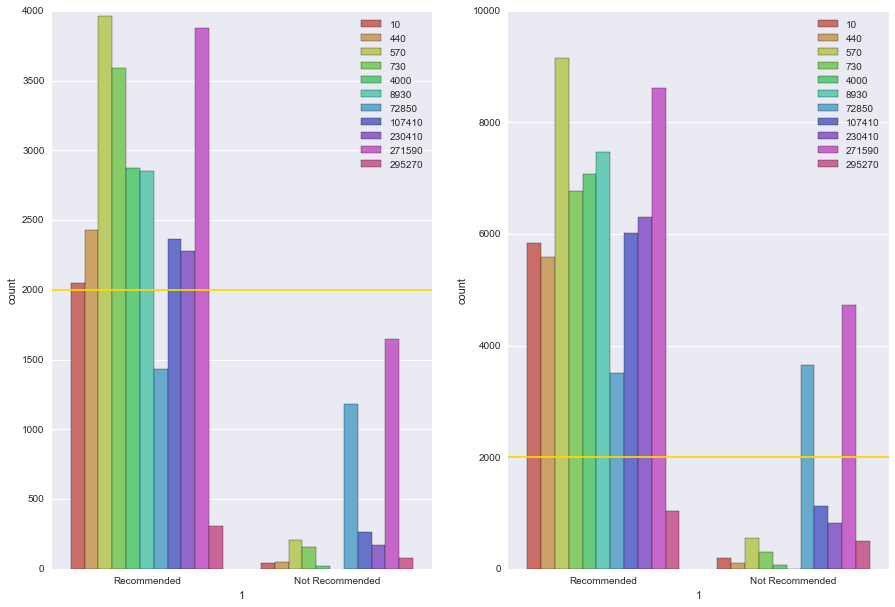

In [215]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
fig = plt.figure(figsize=(8,8))
ax1 = sns.countplot(x=1, data=plott, hue=0, ax=ax1, palette='hls')
ax1.axhline(y=2000, color='gold')
ax2 = sns.countplot(x=1, data=pre_plott, hue=0, ax=ax2, palette='hls')
ax2.axhline(y=2000, color='gold')



Above, the class imbalance that will become more relevant later on in the report.

# 5. Description of model choice

Being able to depict whether or not there is a relationship between the amount of hours a user has played a videogame and the valence of the review they wrote is a very cut-and-dried task. Doing this with a linear regression is quick and easy, it also gives me a sure-fire way to determine whether or not there is a relationship. However this is very subjective due to the fact of my sentiment rating being depcited by a third party module.


# 6. Models

For the sake of maintaining relevance I will only fit and plot on one of the datasets, there are only miniscule differences between each of them when it comes to the difference in hours played and the sentiment score of the review.

### Linear Regression

In [36]:
lr = LinearRegression(normalize=True)

ss = StandardScaler()

formula = 'hours_played_diff ~ sentiment'

y, x    = patsy.dmatrices(formula, data=dota_with_time_nonan_test, return_type='dataframe')

# Standard Scaler because I'm comparing enormous values to a value between -1, and 1
Xn = ss.fit_transform(x)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(Xn, y, test_size=0.25)

In [48]:
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [206]:
print 'lr score:', lr.score(x_test, y_test)

lr score: 0.000698437760814


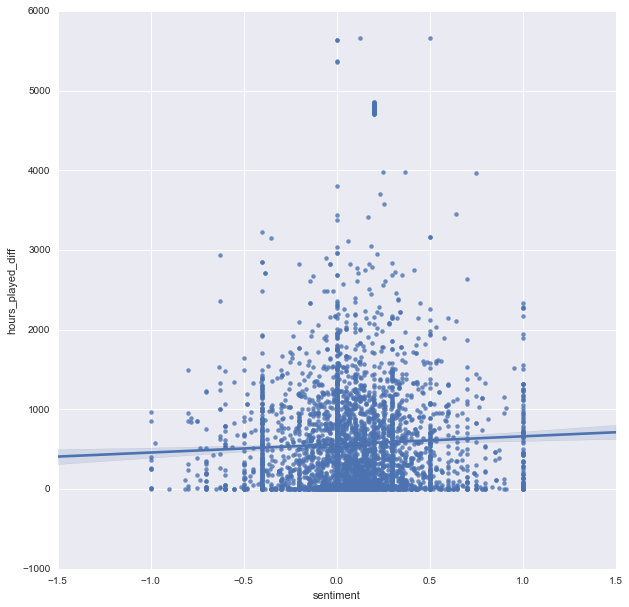

In [59]:
ax = plt.figure(figsize=(10,10))
ax = sns.regplot(x=dota_with_time_nonan_test.sentiment, y=dota_with_time_nonan_test.hours_played_diff)

# 7. Description of results

The regression R^2 score for all games lies around 0.00~ and thus, using the sentiment rating provided by textblob, there is no observable relationship what-so-ever between the amount a user played a videogame beyond their review, and the sentiment of that review. I believe if there were any relationship at all, the score of my model would diverge from 0, regardless of textblob's sentiment score.

From the regplot we can see there are users on both ends of the spectrum, with sentiment scores for their review below zero and more than 1000 additional hours played, and the latter, with sentiment ranging greater than 0.5 and still the additional hours played not exceeding 1000.

These are also very intersting results as there seems to be a pretty even spread amongst the points mapping the difference in hours played and the sentiment of the review, regardless of the class imbalance.

# 8. Conclusions about Sentiment

Looking at the linear regression we can see there is no apparent relationship between the sentiment of one's review and the amount they play the game that they review. It isn't far off to conclude that the amount someone has played is more related with how much they played the videogame at the time of reviewing, versus how positive or negative the review itself is.

# #Part-2 Event Specific Reviews

# 1. Problem Statement

Looking at the class imbalance stated before, there are two games that have a decent distribution of classes, those games are 72850 (Skyrim), 271590 (Grand Theft Auto V). Fitting text analytical models against other game datasets would be problematic as there are so few numbers of reviews that don't recommend the game, compared to the amount of reviews that recommend the game.

# 2. Description of model choice

In order to depict differences between the reviews that recommend and don't recommend the videogame I will use Naive Bayes to predict the likelihood of words appearing in the two different classes of review. This is so I can get immediate results without having to take multiple passes of the data, using a count vectorizer or TFIDF vectorizer I will more or less get the same effect of an LDA in determining common topics amongst the two classes, given the likelihood of the features for each class.

# 3. Models

### Skyrim

In [189]:
custom_stopwords = list(stopwords.words('english'))
skyrimwords = ['game', '10', 'play', 'valve', 'steam', 'like', 'skyrim']
stopword_list = custom_stopwords + skyrimwords

In [190]:
cv= CountVectorizer(stop_words=custom_stopwords, ngram_range=(1, 2), binary=True, max_features=5000)
words = cv.fit_transform(elder_with_time_nonan_test.review)

In [191]:
words_df = pd.DataFrame(words.todense(), columns=cv.get_feature_names())

In [192]:
xtrain, xtest, ytrain, ytest = train_test_split(words_df.values, elder_with_time_nonan_test.rating.values, test_size=0.25)

In [193]:
nb = BernoulliNB()

nb.fit(xtrain, ytrain)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [201]:
baseline = []

for x in ytrain:
    if x == 'Recommended':
        baseline.append(1)
    else:
        baseline.append(0)

In [202]:
nb_scores = cross_val_score(BernoulliNB(), xtrain, ytrain, cv=5)
print nb_scores
print np.mean(nb_scores)

# Baseline
print 1 - np.mean(baseline)

[ 0.70918367  0.71938776  0.69565217  0.75191816  0.71025641]
0.717279634262
0.462167689162


In [79]:
feat_lp = nb.feature_log_prob_
recommend_p = np.exp(feat_lp[1])
not_recommend_p = np.exp(feat_lp[0])
feat_probs = pd.DataFrame({'Recommend':recommend_p, 'Not Recommend':not_recommend_p, 'feature':words_df.columns.values})
feat_probs.sort_values('Not Recommend', ascending=False, inplace=True)
feat_probs.head(10)

,Not Recommend,Recommend,feature
2859,0.697143,0.252535,mods
1611,0.486857,0.621198,game
3242,0.425143,0.035023,paid
3247,0.331429,0.027650,paid mods
4671,0.289143,0.013825,valve
438,0.212571,0.062673,bethesda
2807,0.202286,0.114286,mod
3273,0.184000,0.014747,pay
4024,0.147429,0.321659,skyrim
748,0.145143,0.074654,community


In [216]:
filepath = '../capstone/skyrimfeatures.pkl'
pd.to_pickle(feat_probs.head(10), filepath)

With the features list we can easily see a pattern of reviews that don't recommend the game talking about 'paid mods' this is directly related with the game creators, Bethesda, making modifications to their game under any circumstance an expense. This causes much controversy as there are many games on steam which allow users to modify the game for free, as well as use other user's created modifications for free.

I believe this is no more than a knee-jerk reaction by the community in response to mods not being free anymore.

In [80]:
custom_stopwords = list(stopwords.words('english'))
gtawords = ['game', '10', 'play', 'valve', 'steam', 'like', 'grand', 'theft', 'auto', 'gta']
stopword_list = custom_stopwords + skyrimwords

In [81]:
cv= CountVectorizer(stop_words=custom_stopwords, ngram_range=(1, 2), binary=True, max_features=5000)
words = cv.fit_transform(gta_with_time_nonan_test.review)

In [82]:
words_df = pd.DataFrame(words.todense(), columns=cv.get_feature_names())

In [83]:
xtrain, xtest, ytrain, ytest = train_test_split(words_df.values, gta_with_time_nonan_test.rating.values, test_size=0.25)

In [84]:
nb = BernoulliNB()

nb.fit(xtrain, ytrain)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [188]:
nb_scores = cross_val_score(BernoulliNB(), xtrain, ytrain, cv=5)
print nb_scores
print np.mean(nb_scores)

# Baseline
print  1 - np.mean(ytrain)

[ 0.56581197  0.59316239  0.56581197  0.48888889  0.57777778]
0.558290598291
0.577777777778


In [90]:
feat_lp = nb.feature_log_prob_
recommend_p = np.exp(feat_lp[1])
not_recommend_p = np.exp(feat_lp[0])
feat_probs = pd.DataFrame({'Recommend':recommend_p, 'Not Recommend':not_recommend_p, 'feature':words_df.columns.values})
feat_probs.sort_values('Not Recommend', ascending=False, inplace=True)
feat_probs.head(10)

,Not Recommend,Recommend,feature
1590,0.666667,0.562715,game
3846,0.399038,0.128877,rockstar
3938,0.259615,0.017574,sale
3513,0.248397,0.023432,price
3277,0.240385,0.085803,people
2048,0.231571,0.232943,gta
3094,0.223558,0.199173,online
1851,0.219551,0.135768,get
2543,0.196314,0.139904,like
2898,0.188301,0.062715,money


Driven by the result of the last model, I was interested in why 'price' and 'sale' as features were more likely to apear in the reviews that don't recommend Grand Theft Auto,  as it turns out, when the game was released in April of 2015. This was right in the middle of a "Steam Summer Sale" in which players can buy all of the games they've kept their eye on at a cheaper price.

Players thought they had found a discounted GTA5, however what they got was a marked up price, discounted, almost to the original price of the game, and even at that, it wasn't the game itself, but ingame points that were discounted.

# 7. Description of results

Under both games we can see a likelihood of words in reviews that dont recommend the game, that relate to decisions the videogame creators make. Perhaps the topics talked about in reviews pertain specifically to what surrounds the game and the community of the game at the time of the review being posted.

In order to test this I will perform another Naive Bayes Classification on the DotA 2 reviews I have, predicting the specific times in which it's biggest tournament of the year, The International, is happening.

In [92]:
dota_df['date_posted'] = pd.to_datetime(dota_df['date_posted'])
# This is a subset of the original review data, so there are no exclusions due to the profile being unretrievable

#03/09/2014 is two months before the prize pool for the international opened up, 09/21/2014 is two months after the international concluded.
dota_international_2014_lr = dota_df[(dota_df['date_posted'] >= pd.to_datetime('03/09/2014')) & (dota_df['date_posted'] <= pd.to_datetime('09/21/2014'))]

dota_international_2014_lr['tourneytime'] = dota_international_2014_lr['date_posted'].map(lambda x: 1 if (x >= pd.to_datetime('05/09/2014')) & (x <= pd.to_datetime('07/21/2014')) else 0)

/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [229]:
custom_stopwords = list(stopwords.words('english'))
common_stopwords = ['game', '10', 'play', 'valve', 'steam', 'like', 'dota', 'get', 'life']
stopword_list = custom_stopwords + common_stopwords

In [230]:
cv_i = CountVectorizer(stop_words=stopword_list, ngram_range=(2, 2), binary=True, max_features=6000)
words_i = cv_i.fit_transform(dota_international_2014_lr.review)
international_words = pd.DataFrame(words_i.todense(), columns=cv_i.get_feature_names())

In [231]:
xtrain, xtest, ytrain, ytest = train_test_split(international_words.values, dota_international_2014_lr.tourneytime.values, test_size=0.25)

In [232]:
inb = BernoulliNB()

In [233]:
inb.fit(xtrain, ytrain)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [234]:
nb_scores = cross_val_score(BernoulliNB(), xtest, ytest, cv=10)
print nb_scores
print np.mean(nb_scores)

#Baseline
print 1 - np.mean(ytrain)

[ 0.59183673  0.51020408  0.57142857  0.57142857  0.62244898  0.6122449
  0.58163265  0.60824742  0.61458333  0.51041667]
0.579447191248
0.579145299145


In [235]:
predictions = inb.predict(xtest)
print classification_report(ytest, predictions)
confmat = confusion_matrix(y_true=ytest, y_pred=inb.predict(xtest))

confusion = pd.DataFrame(confmat, index=['is not tourneytime', 'is tourneytime'],
                         columns=['predicted is not tourneytime','predicted is tourneytime'])

confusion

             precision    recall  f1-score   support

          0       0.68      0.25      0.37       558
          1       0.46      0.84      0.59       417

avg / total       0.58      0.50      0.46       975



,predicted is not tourneytime,predicted is tourneytime
is not tourneytime,142,416
is tourneytime,67,350


In [236]:
fpr = dict()
tpr = dict()

fpr[1], tpr[1], thresh = roc_curve(ytrain, inb.predict_proba(xtrain)[:,1])
fpr[2], tpr[2], thresh = roc_curve(ytest, inb.predict_proba(xtest)[:,1])

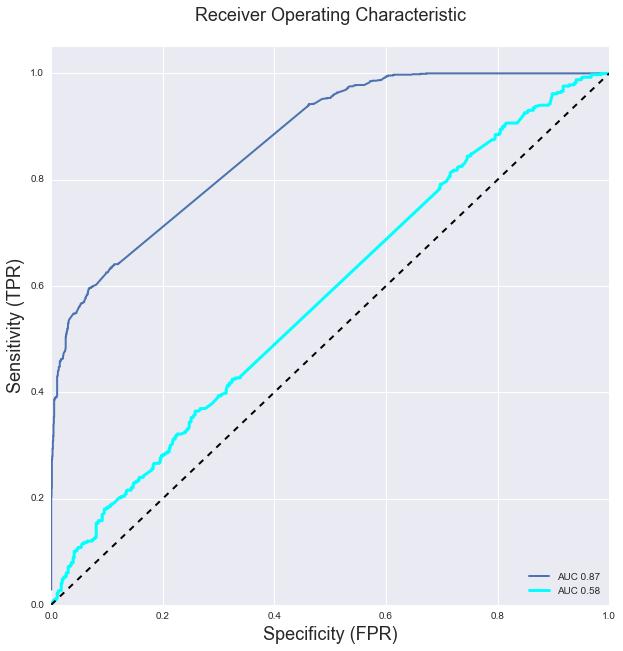

In [237]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

roc_auc = auc(fpr[1], tpr[1])
ax = plt.plot(fpr[1], tpr[1], lw=2,
             label='AUC '+'{0:.2f}'.format(roc_auc))




roc_auc_2 = auc(fpr[2], tpr[2])
ax = plt.plot(fpr[2], tpr[2], lw=3, color='cyan',
              label='AUC '+'{0:.2f}'.format(roc_auc_2))

        
# 50 / 50 line
ax = plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity (FPR)', fontsize=18)
plt.ylabel('Sensitivity (TPR)', fontsize=18)
plt.title('Receiver Operating Characteristic\n', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## 8. Conclusions about event-specific reviews

More often than not, performing worse than the baseline, this model shows there is not a clear distinction between reviews that happen before, after, and during festivities surounding a videogame and it's community.

The results from the previous Naive Bayes model show what I believe is summed up as buyer's remorse. Very similar to when you go to a restaraunt, get bad service, then effectively write a yelp review of that service, updating the stature of that restaraunt accordingly, these players felt neglected in some way and thus posted reviews to update Bethesda's or Rockstar Games' stature. 

I definetly believe there are more conclusions to be made about how a video game company's behavior in the public eye can effect it's reviews both on the side of topics and nature of those topics, and on the side of sentiment. However change in sentiment is not related to the change in hours a reviewer has played the videogame they reviewed.